# R2: Delphi Comparison Using Phecode-Based ICD Mapping

This notebook creates a principled comparison between Aladynoulli and Delphi-2M by:

1. **Disease Name → Phenotype Names**: Using our `major_diseases` mapping from `evaluate_major_disease_wsex_rolling_tte.py`
2. **Phenotype Names → Phecodes**: Looking up phenotype names in the Phecode mapping file
3. **Phecodes → ICD Codes**: Extracting all ICD codes that map to those Phecodes
4. **ICD Codes → Delphi Results**: Extracting Delphi's "no gap" (t0) predictions for those ICD codes
5. **Comparison**: Our t0 predictions (`washout_0yr_results.csv`) vs Delphi's t0 predictions

This ensures we use the **actual Phecode→ICD aggregation** that our model uses, rather than manual approximations.

## Key Insight

This comparison is **more principled** than manual ICD mappings because:
- It uses the same Phecode aggregation logic that our model uses
- It captures all ICD codes that contribute to each Phecode
- It ensures fair comparison by matching on the same disease definitions

---


In [41]:
import pandas as pd
import pandas as pd
import numpy as np
from pathlib import Path
import sys


In [42]:

# Load major_diseases mapping from evaluate_major_disease_wsex_rolling_tte.py
major_diseases = {
    'ASCVD': ['Myocardial infarction', 'Coronary atherosclerosis', 'Other acute and subacute forms of ischemic heart disease', 
              'Unstable angina (intermediate coronary syndrome)', 'Angina pectoris', 'Other chronic ischemic heart disease, unspecified'],
    'Diabetes': ['Type 2 diabetes'],
    'Atrial_Fib': ['Atrial fibrillation and flutter'],
    'CKD': ['Chronic renal failure [CKD]', 'Chronic Kidney Disease, Stage III'],
    'All_Cancers': ['Colon cancer', 'Cancer of bronchus; lung', 'Cancer of prostate', 'Malignant neoplasm of bladder', 'Secondary malignant neoplasm','Secondary malignant neoplasm of digestive systems', 'Secondary malignant neoplasm of liver'],
    'Stroke': ['Cerebral artery occlusion, with cerebral infarction', 'Cerebral ischemia'],
    'Heart_Failure': ['Congestive heart failure (CHF) NOS', 'Heart failure NOS'],
    'Pneumonia': ['Pneumonia', 'Bacterial pneumonia', 'Pneumococcal pneumonia'],
    'COPD': ['Chronic airway obstruction', 'Emphysema', 'Obstructive chronic bronchitis'],
    'Osteoporosis': ['Osteoporosis NOS'],
    'Anemia': ['Iron deficiency anemias, unspecified or not due to blood loss', 'Other anemias'],
    'Colorectal_Cancer': ['Colon cancer', 'Malignant neoplasm of rectum, rectosigmoid junction, and anus'],
    'Breast_Cancer': ['Breast cancer [female]', 'Malignant neoplasm of female breast'],
    'Prostate_Cancer': ['Cancer of prostate'],
    'Lung_Cancer': ['Cancer of bronchus; lung'],
    'Bladder_Cancer': ['Malignant neoplasm of bladder'],
    'Secondary_Cancer': ['Secondary malignant neoplasm', 'Secondary malignancy of lymph nodes', 'Secondary malignancy of respiratory organs', 'Secondary malignant neoplasm of digestive systems'],
    'Depression': ['Major depressive disorder'],
    'Anxiety': ['Anxiety disorder'],
    'Bipolar_Disorder': ['Bipolar'],
    'Rheumatoid_Arthritis': ['Rheumatoid arthritis'],
    'Psoriasis': ['Psoriasis vulgaris'],
    'Ulcerative_Colitis': ['Ulcerative colitis'],
    'Crohns_Disease': ['Regional enteritis'],
    'Asthma': ['Asthma'],
    'Parkinsons': ["Parkinson's disease"],
    'Multiple_Sclerosis': ['Multiple sclerosis'],
    'Thyroid_Disorders': ['Thyrotoxicosis with or without goiter', 'Secondary hypothyroidism', 'Hypothyroidism NOS']
}

print(f"✓ Loaded {len(major_diseases)} disease mappings")
print(f"\nExample mappings:")
for disease, phenotypes in list(major_diseases.items())[:3]:
    print(f"  {disease}: {phenotypes}")

✓ Loaded 28 disease mappings

Example mappings:
  ASCVD: ['Myocardial infarction', 'Coronary atherosclerosis', 'Other acute and subacute forms of ischemic heart disease', 'Unstable angina (intermediate coronary syndrome)', 'Angina pectoris', 'Other chronic ischemic heart disease, unspecified']
  Diabetes: ['Type 2 diabetes']
  Atrial_Fib: ['Atrial fibrillation and flutter']



## Step 2: Load Phecode Mapping File

Load the Phecode mapping file that contains ICD-10 → Phecode mappings. This file also contains phenotype names that we can match against.

In [138]:
# Try to load Phecode mapping file
phecode_mapping_paths = [
    '/Users/sarahurbut/Library/aladynoulli2/noulli_mapped_phecode_icd10cm.rds',
    #'/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode.csv',
    #'/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/icd2phecode_mergedwithdetailedphecode_info.csv',
]

phecode_mapping_df = None
for path in phecode_mapping_paths:
    if Path(path).exists():
        if path.endswith('.rds'):
            if HAS_PYREADR:
                try:
                    result = pyreadr.read_r(str(path))
                    phecode_mapping_df = result[None]
                    print(f"✓ Loaded Phecode mapping from RDS: {len(phecode_mapping_df)} rows")
                    break
                except Exception as e:
                    print(f"⚠️  Error loading RDS: {e}")
            else:
                print("⚠️  pyreadr not available, trying CSV...")
        else:
            try:
                phecode_mapping_df = pd.read_csv(path)
                print(f"✓ Loaded Phecode mapping from CSV: {len(phecode_mapping_df)} rows")
                break
            except Exception as e:
                print(f"⚠️  Error loading CSV: {e}")

if phecode_mapping_df is None:
    print("⚠️  Phecode mapping file not found!")
    print("   Expected locations:")
    for path in phecode_mapping_paths:
        print(f"     {path}")
else:
    print(f"\nColumns in mapping file: {phecode_mapping_df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(phecode_mapping_df.head())


⚠️  Phecode mapping file not found!
   Expected locations:
     /Users/sarahurbut/Library/aladynoulli2/noulli_mapped_phecode_icd10cm.rds



## Step 3: Map Phenotype Names → Phecodes → ICD Codes

For each disease, find the Phecodes that match its phenotype names, then extract all ICD codes that map to those Phecodes.

In [139]:
import pyreadr

phecode_mapping_path = '/Users/sarahurbut/aladynoulli2/noulli_mapped_phecode_icd10cm.rds'

if Path(phecode_mapping_path).exists():
    try:
        result = pyreadr.read_r(phecode_mapping_path)
        phecode_mapping_df = result[None]
        print(f"✓ Loaded Phecode mapping from RDS: {len(phecode_mapping_df)} rows")
        print(f"\nColumns in mapping file: {phecode_mapping_df.columns.tolist()}")
        print(f"\nFirst few rows:")
        print(phecode_mapping_df.head())
    except Exception as e:
        print(f"⚠️  Error loading RDS: {e}")
        phecode_mapping_df = None
else:
    print(f"⚠️  File not found: {phecode_mapping_path}")
    phecode_mapping_df = None

✓ Loaded Phecode mapping from RDS: 14046 rows

Columns in mapping file: ['phecode', 'ICD10', 'phenotype']

First few rows:
   phecode  ICD10            phenotype
0      8.5  A0229  Bacterial enteritis
1      8.5   A039  Bacterial enteritis
2      8.5   A050  Bacterial enteritis
3      8.5   A030  Bacterial enteritis
4      8.5   A053  Bacterial enteritis


In [140]:
# Map disease → phenotype → ICD10 codes directly from phecode_mapping_df
# For each disease, find rows where 'phenotype' column matches phenotype names, then extract 'diag_icd10' codes
disease_to_icd_mapping = {}

if phecode_mapping_df is not None:
    # Use correct column names from the mapping file
    phenotype_col = 'phenotype'  # Column with phenotype names
    icd10_col = 'ICD10'  # Column with ICD10 codes
    
    for disease_name, phenotype_list in major_diseases.items():
        matched_icd10_codes = set()
        matched_phenotypes = []
        
        # For each phenotype in the disease, find matching rows in phecode_mapping_df
        for phenotype in phenotype_list:
            # Match phenotype name in the 'phenotype' column (case-insensitive)
            matches = phecode_mapping_df[
                phecode_mapping_df[phenotype_col].str.contains(phenotype, case=False, na=False, regex=False)
            ]
            
            if len(matches) > 0:
                # Extract unique ICD10 codes from matching rows
                icd10_codes = matches[icd10_col].dropna().unique()
                matched_icd10_codes.update(icd10_codes)
                matched_phenotypes.append(phenotype)
                print(f"  ✓ {phenotype}: {len(icd10_codes)} ICD10 codes")
        
        disease_to_icd_mapping[disease_name] = {
            'phenotypes': phenotype_list,
            'matched_phenotypes': matched_phenotypes,
            'icd10_codes': sorted(list(matched_icd10_codes))
        }
        
        print(f"{disease_name}: {len(matched_phenotypes)}/{len(phenotype_list)} phenotypes matched, {len(matched_icd10_codes)} unique ICD10 codes")
    
    print(f"\n✓ Mapped {len(disease_to_icd_mapping)} diseases to ICD10 codes")
    
    # Show summary
    print("\nSummary:")
    for disease, mapping in list(disease_to_icd_mapping.items())[:5]:
        print(f"  {disease}: {len(mapping['icd10_codes'])} ICD10 codes")
        if len(mapping['icd10_codes']) > 0:
            print(f"    Examples: {mapping['icd10_codes'][:5]}")
else:
    print("⚠️  Cannot create mapping without Phecode file")



  ✓ Myocardial infarction: 34 ICD10 codes
  ✓ Coronary atherosclerosis: 36 ICD10 codes
  ✓ Other acute and subacute forms of ischemic heart disease: 2 ICD10 codes
  ✓ Unstable angina (intermediate coronary syndrome): 1 ICD10 codes
  ✓ Angina pectoris: 4 ICD10 codes
  ✓ Other chronic ischemic heart disease, unspecified: 6 ICD10 codes
ASCVD: 6/6 phenotypes matched, 83 unique ICD10 codes
  ✓ Type 2 diabetes: 23 ICD10 codes
Diabetes: 1/1 phenotypes matched, 23 unique ICD10 codes
  ✓ Atrial fibrillation and flutter: 1 ICD10 codes
Atrial_Fib: 1/1 phenotypes matched, 1 unique ICD10 codes
  ✓ Chronic renal failure [CKD]: 2 ICD10 codes
  ✓ Chronic Kidney Disease, Stage III: 1 ICD10 codes
CKD: 2/2 phenotypes matched, 3 unique ICD10 codes
  ✓ Colon cancer: 23 ICD10 codes
  ✓ Cancer of bronchus; lung: 33 ICD10 codes
  ✓ Cancer of prostate: 3 ICD10 codes
  ✓ Malignant neoplasm of bladder: 12 ICD10 codes
  ✓ Secondary malignant neoplasm: 35 ICD10 codes
  ✓ Secondary malignant neoplasm of digestive s

In [141]:
# Load Delphi supplementary table
delphi_supp_paths = [
    '/Users/sarahurbut/Downloads/41586_2025_9529_MOESM3_ESM.csv',
    '/Users/sarahurbut/aladynoulli2/claudefile/output/delphi_supplementary.csv',
]

delphi_supp = None
for path in delphi_supp_paths:
    if Path(path).exists():
        try:
            delphi_supp = pd.read_csv(path)
            print(f"✓ Loaded Delphi supplementary table: {len(delphi_supp)} rows")
            print(f"  Columns: {delphi_supp.columns.tolist()}")
            break
        except Exception as e:
            print(f"⚠️  Error loading {path}: {e}")

if delphi_supp is None:
    print("⚠️  Delphi supplementary table not found!")
    print("   Expected locations:")
    for path in delphi_supp_paths:
        print(f"     {path}")
else:
    print(f"\nFirst few rows:")
    print(delphi_supp.head())


✓ Loaded Delphi supplementary table: 1270 rows
  Columns: ['Index', 'Name', 'ICD-10 Chapter', 'ICD-10 Chapter (short)', 'Colour', 'AUC Female, (no gap)', 'AUC Male, (no gap)', 'AUC Female, (1 year gap)', 'AUC Male, (1 year gap)', 'N tokens, training', 'N tokens, validation']

First few rows:
   Index     Name            ICD-10 Chapter    ICD-10 Chapter (short)  \
0      0  Padding                 Technical                 Technical   
1      1  Healthy                 Technical                 Technical   
2      2   Female                       Sex                       Sex   
3      3     Male                       Sex                       Sex   
4      4  BMI low  Smoking, Alcohol and BMI  Smoking, Alcohol and BMI   

    Colour  AUC Female, (no gap)  AUC Male, (no gap)  \
0  #2a52be                   NaN                 NaN   
1  #2a52be                   NaN                 NaN   
2  #bcbd22                   NaN                 NaN   
3  #bcbd22                   NaN            

## Step 5: Extract Delphi Results Using ICD10 Codes

Match the ICD10 codes from our phecode mapping against Delphi's table to extract AUC results.


In [142]:
# Extract Delphi AUCs for each disease using ICD10 codes from phecode mapping
# Match ICD10 codes from disease_to_icd_mapping against Delphi table
delphi_results = []

if delphi_supp is not None and 'disease_to_icd_mapping' in locals():
    # Identify Delphi column names
    name_col = None
    auc_0gap_female_col = None
    auc_0gap_male_col = None
    
    for col in delphi_supp.columns:
        col_lower = col.lower()
        if 'name' in col_lower and name_col is None:
            name_col = col
        if 'auc' in col_lower and 'female' in col_lower and 'no gap' in col_lower:
            auc_0gap_female_col = col
        if 'auc' in col_lower and 'male' in col_lower and 'no gap' in col_lower:
            auc_0gap_male_col = col
    
    print(f"Delphi columns identified:")
    print(f"  Name: {name_col}")
    print(f"  AUC Female (0 gap): {auc_0gap_female_col}")
    print(f"  AUC Male (0 gap): {auc_0gap_male_col}")
    
    if name_col:
        for disease_name, mapping_info in disease_to_icd_mapping.items():
            icd10_codes = mapping_info['icd10_codes']
            
            if len(icd10_codes) == 0:
                print(f"⚠️  {disease_name}: No ICD10 codes found from phecode mapping")
                continue
            
            # Match ICD10 codes against Delphi table
            # Delphi Name column contains ICD codes like "I21 Acute myocardial infarction"
            matching_rows = []
            matched_icd10_codes = []
            
            for icd10_code in icd10_codes:
                # Extract first 3 characters (Delphi uses 3-character codes like "I21", "E11", "N18")
                # Our phecode mapping gives 4-character codes like "I236", "E114", "N183"
                icd10_base = icd10_code[:3]  # e.g., "I236" -> "I23", "E114" -> "E11"
                
                # Match ICD codes that start with the 3-character pattern (e.g., "I21" matches "I21 Acute myocardial infarction")
                matches = delphi_supp[
                    delphi_supp[name_col].str.contains(f'^{icd10_base}', regex=True, case=False, na=False)
                ]
                
                if len(matches) > 0:
                    matching_rows.append(matches)
                    matched_icd10_codes.append(icd10_code)
                    print(f"  ✓ {disease_name}: ICD10 {icd10_code} ({icd10_base}) → {len(matches)} Delphi matches")
            
            if len(matching_rows) > 0:
                # Combine all matching rows
                combined = pd.concat(matching_rows).drop_duplicates()
                
                # Create one row per Delphi ICD code match (1-to-many structure)
                import re
                
                for idx, row in combined.iterrows():
                    # Extract ICD code and name from Delphi row
                    icd_code = None
                    delphi_name = None
                    if name_col in row.index:
                        name_val = str(row[name_col])
                        delphi_name = name_val
                        icd_match = re.match(r'^([A-Z]\d{2})', name_val)
                        if icd_match:
                            icd_code = icd_match.group(1)
                    
                    # Collect both female and male AUCs
                    female_auc = None
                    male_auc = None
                    
                    if auc_0gap_female_col and auc_0gap_female_col in row.index and pd.notna(row[auc_0gap_female_col]):
                        female_auc = row[auc_0gap_female_col]
                    
                    if auc_0gap_male_col and auc_0gap_male_col in row.index and pd.notna(row[auc_0gap_male_col]):
                        male_auc = row[auc_0gap_male_col]
                    
                    # Average male and female if both available, otherwise use available one
                    if female_auc is not None and male_auc is not None:
                        avg_auc = (female_auc + male_auc) / 2
                    elif female_auc is not None:
                        avg_auc = female_auc
                    elif male_auc is not None:
                        avg_auc = male_auc
                    else:
                        continue  # Skip if no AUC available
                    
                    # Create one row per Delphi ICD code match
                    delphi_results.append({
                        'Disease': disease_name,
                        'Delphi_t0': avg_auc,
                        'Delphi_ICD_code': icd_code if icd_code else '',
                        'Delphi_name': delphi_name if delphi_name else '',
                        'Delphi_female_auc': female_auc if female_auc is not None else np.nan,
                        'Delphi_male_auc': male_auc if male_auc is not None else np.nan,
                        'N_ICD10_codes_matched': len(matched_icd10_codes),
                        'N_ICD10_codes_total': len(icd10_codes),
                        'Matched_ICD10_codes': ', '.join(matched_icd10_codes[:5]) + ('...' if len(matched_icd10_codes) > 5 else '')
                    })
            else:
                print(f"⚠️  {disease_name}: No Delphi matches found for {len(icd10_codes)} ICD10 codes")
    
    delphi_df = pd.DataFrame(delphi_results)
    print(f"\n" + "="*80)
    print(f"✓ Extracted Delphi results: {len(delphi_df)} ICD code matches across {len(set(delphi_df['Disease']))} diseases")
    print("="*80)
    if len(delphi_df) > 0:
        print(f"\nDelphi results summary (1-to-many structure):")
        print(f"  Total Delphi ICD code matches: {len(delphi_df)}")
        print(f"  Unique diseases: {len(set(delphi_df['Disease']))}")
        print(f"\nExample (showing all ICD codes for first disease):")
        first_disease = delphi_df['Disease'].iloc[0]
        print(delphi_df[delphi_df['Disease'] == first_disease][['Disease', 'Delphi_ICD_code', 'Delphi_t0', 'Delphi_name']].to_string(index=False))
else:
    print("⚠️  Cannot extract Delphi results without Delphi table or disease_to_icd_mapping")


Delphi columns identified:
  Name: Name
  AUC Female (0 gap): AUC Female, (no gap)
  AUC Male (0 gap): AUC Male, (no gap)
  ✓ ASCVD: ICD10 I20 (I20) → 1 Delphi matches
  ✓ ASCVD: ICD10 I200 (I20) → 1 Delphi matches
  ✓ ASCVD: ICD10 I201 (I20) → 1 Delphi matches
  ✓ ASCVD: ICD10 I208 (I20) → 1 Delphi matches
  ✓ ASCVD: ICD10 I209 (I20) → 1 Delphi matches
  ✓ ASCVD: ICD10 I21 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I210 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2101 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2102 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2109 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I211 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2111 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2119 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I212 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2121 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I2129 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I213 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I214 (I21) → 1 Delphi matches
  ✓ ASCVD: ICD10 I219 (I21)

## Step 6: Load Aladynoulli t0 Predictions

Load our t0 predictions from `washout_0yr_results.csv` (predictions at enrollment, 0-year washout).


In [143]:
# Load Aladynoulli t0 predictions (0-year washout = predictions at enrollment)
aladynoulli_t0_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/washout/pooled_retrospective/washout_0yr_results.csv')

if aladynoulli_t0_path.exists():
    aladynoulli_t0 = pd.read_csv(aladynoulli_t0_path)
    aladynoulli_t0 = aladynoulli_t0[['Disease', 'AUC']].copy()
    aladynoulli_t0.columns = ['Disease', 'Aladynoulli_t0']
    
    print(f"✓ Loaded Aladynoulli t0 predictions for {len(aladynoulli_t0)} diseases")
    print(f"\nTop 10 diseases by AUC:")
    print(aladynoulli_t0.nlargest(10, 'Aladynoulli_t0')[['Disease', 'Aladynoulli_t0']].to_string(index=False))
else:
    print(f"⚠️  Aladynoulli results file not found: {aladynoulli_t0_path}")
    aladynoulli_t0 = None


✓ Loaded Aladynoulli t0 predictions for 28 diseases

Top 10 diseases by AUC:
           Disease  Aladynoulli_t0
    Crohns_Disease        0.896424
             ASCVD        0.880921
Multiple_Sclerosis        0.839507
   Prostate_Cancer        0.831185
 Colorectal_Cancer        0.825333
    Bladder_Cancer        0.824517
Ulcerative_Colitis        0.816088
        Parkinsons        0.809074
        Atrial_Fib        0.796554
     Breast_Cancer        0.781816


## Step 7: Compare Aladynoulli vs Delphi (t0 predictions)

Compare our t0 predictions (0-year washout) against Delphi's t0 predictions (no gap) using the 1-to-many structure.


In [144]:
# Merge and compare (1-to-many structure)
# Our t0 predictions vs Delphi's t0 predictions (no gap)
if aladynoulli_t0 is not None and len(delphi_results) > 0:
    # Merge: our 1 prediction per disease with ALL Delphi ICD code matches
    comparison = aladynoulli_t0.merge(
        delphi_df[['Disease', 'Delphi_t0', 'Delphi_ICD_code', 'Delphi_name']],
        on='Disease',
        how='inner'
    )
    
    comparison['Advantage'] = comparison['Aladynoulli_t0'] - comparison['Delphi_t0']
    comparison = comparison.sort_values(['Disease', 'Advantage'], ascending=[True, False])
    
    print("="*80)
    print("ALADYNOULLI vs DELPHI: t0 PREDICTIONS (1-to-Many Comparison)")
    print("="*80)
    print(f"\n{len(comparison)} comparisons ({len(set(comparison['Disease']))} diseases)")
    print(f"  Our model: 1 aggregated prediction per disease (0-year washout)")
    print(f"  Delphi: Multiple ICD code predictions per disease (no gap)")
    
    # Count wins: our prediction beats at least one Delphi ICD code
    wins_by_disease = comparison.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).any())
    n_wins = wins_by_disease.sum()
    n_diseases = len(wins_by_disease)
    
    print(f"\nAladynoulli wins (beats at least one Delphi ICD code): {n_wins}/{n_diseases} diseases ({n_wins/n_diseases*100:.1f}%)")
    
    # Count how many Delphi ICD codes we beat per disease
    beats_count = comparison.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).sum())
    total_delphi_codes = comparison.groupby('Disease').size()
    
    print(f"\nMean advantage: {comparison['Advantage'].mean():.4f}")
    print(f"Median advantage: {comparison['Advantage'].median():.4f}")
    
    print("\n" + "-"*80)
    print("Example: ASCVD (showing all Delphi ICD code comparisons):")
    print("-"*80)
    if 'ASCVD' in comparison['Disease'].values:
        ascdv_comparison = comparison[comparison['Disease'] == 'ASCVD']
        print(ascdv_comparison[['Disease', 'Aladynoulli_t0', 'Delphi_ICD_code', 'Delphi_t0', 'Advantage']].to_string(index=False))
    
    # Save results (1-to-many structure)
    output_dir = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/comparisons/pooled_retrospective')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    comparison_save = comparison.copy()
    comparison_save['Win?'] = comparison_save['Advantage'].apply(lambda x: '✓' if x > 0 else '✗')
    comparison_save = comparison_save.sort_values(['Disease', 'Advantage'], ascending=[True, False])
    comparison_save.to_csv(output_dir / 'delphi_comparison_phecode_mapping_t0_1tomany.csv', index=False)
    print(f"\n✓ Results saved to: {output_dir / 'delphi_comparison_phecode_mapping_t0_1tomany.csv'}")
else:
    print("⚠️  Cannot create comparison without both Aladynoulli and Delphi results")


ALADYNOULLI vs DELPHI: t0 PREDICTIONS (1-to-Many Comparison)

82 comparisons (28 diseases)
  Our model: 1 aggregated prediction per disease (0-year washout)
  Delphi: Multiple ICD code predictions per disease (no gap)

Aladynoulli wins (beats at least one Delphi ICD code): 19/28 diseases (67.9%)

Mean advantage: -0.0244
Median advantage: -0.0462

--------------------------------------------------------------------------------
Example: ASCVD (showing all Delphi ICD code comparisons):
--------------------------------------------------------------------------------
Disease  Aladynoulli_t0 Delphi_ICD_code  Delphi_t0  Advantage
  ASCVD        0.880921             I21   0.650164   0.230757
  ASCVD        0.880921             I20   0.731225   0.149696
  ASCVD        0.880921             I25   0.823853   0.057068
  ASCVD        0.880921             I51   0.830445   0.050476
  ASCVD        0.880921             I24   0.849424   0.031497
  ASCVD        0.880921             I23   0.896105  -0.0151

## Step 9: Load Aladynoulli Median 1-Year Predictions

Load our median 1-year predictions (washout 0) from the age_offset results.


In [145]:
# Load Aladynoulli median 1-year predictions (washout 0)
aladynoulli_1yr_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/age_offset/pooled_retrospective/medians_with_global0.csv')

if aladynoulli_1yr_path.exists():
    aladynoulli_1yr = pd.read_csv(aladynoulli_1yr_path)
    aladynoulli_1yr = aladynoulli_1yr[['Disease', 'Median_with_global0']].copy()
    aladynoulli_1yr.columns = ['Disease', 'Aladynoulli_1yr']
    
    print(f"✓ Loaded Aladynoulli median 1-year predictions for {len(aladynoulli_1yr)} diseases")
    print(f"\nTop 10 diseases by AUC:")
    print(aladynoulli_1yr.nlargest(10, 'Aladynoulli_1yr')[['Disease', 'Aladynoulli_1yr']].to_string(index=False))
else:
    print(f"⚠️  Aladynoulli 1-year results file not found: {aladynoulli_1yr_path}")
    aladynoulli_1yr = None


✓ Loaded Aladynoulli median 1-year predictions for 28 diseases

Top 10 diseases by AUC:
             Disease  Aladynoulli_1yr
      Crohns_Disease         0.929851
  Multiple_Sclerosis         0.901502
      Bladder_Cancer         0.890949
               ASCVD         0.879477
       Breast_Cancer         0.867449
   Colorectal_Cancer         0.848056
     Prostate_Cancer         0.828300
       Heart_Failure         0.810593
  Ulcerative_Colitis         0.809364
Rheumatoid_Arthritis         0.801110


## Step 10: Compare Aladynoulli vs Delphi (1-Year Predictions)

Compare our median 1-year predictions (washout 0) against Delphi's 1-year gap predictions using the 1-to-many structure.


In [146]:
# Merge and compare (1-to-many structure)
# Our median 1-year predictions (washout 0) vs Delphi's no gap (t0) predictions
if aladynoulli_1yr is not None and 'delphi_df' in locals() and len(delphi_df) > 0:
    # Use Delphi t0 (no gap) predictions
    delphi_t0 = delphi_df[delphi_df['Delphi_t0'].notna()].copy()
    
    if len(delphi_t0) > 0:
        # Merge: our 1 prediction per disease with ALL Delphi ICD code matches
        comparison_1yr = aladynoulli_1yr.merge(
            delphi_t0[['Disease', 'Delphi_t0', 'Delphi_ICD_code', 'Delphi_name']],
            on='Disease',
            how='inner'
        )
        
        # Rename for clarity
        comparison_1yr = comparison_1yr.rename(columns={'Delphi_t0': 'Delphi_no_gap'})
        comparison_1yr['Advantage'] = comparison_1yr['Aladynoulli_1yr'] - comparison_1yr['Delphi_no_gap']
        comparison_1yr = comparison_1yr.sort_values(['Disease', 'Advantage'], ascending=[True, False])
        
        print("="*80)
        print("ALADYNOULLI vs DELPHI: 1-YEAR PREDICTIONS (1-to-Many Comparison)")
        print("="*80)
        print(f"\n{len(comparison_1yr)} comparisons ({len(set(comparison_1yr['Disease']))} diseases)")
        print(f"  Our model: 1 median aggregated prediction per disease (1-year, washout 0)")
        print(f"  Delphi: Multiple ICD code predictions per disease (no gap / t0)")
        
        # Count wins: our prediction beats at least one Delphi ICD code
        wins_by_disease = comparison_1yr.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).any())
        n_wins = wins_by_disease.sum()
        n_diseases = len(wins_by_disease)
        
        print(f"\nAladynoulli wins (beats at least one Delphi ICD code): {n_wins}/{n_diseases} diseases ({n_wins/n_diseases*100:.1f}%)")
        
        print(f"\nMean advantage: {comparison_1yr['Advantage'].mean():.4f}")
        print(f"Median advantage: {comparison_1yr['Advantage'].median():.4f}")
        
        print("\n" + "-"*80)
        print("Example: ASCVD (showing all Delphi ICD code comparisons):")
        print("-"*80)
        if 'ASCVD' in comparison_1yr['Disease'].values:
            ascdv_comparison = comparison_1yr[comparison_1yr['Disease'] == 'ASCVD']
            print(ascdv_comparison[['Disease', 'Aladynoulli_1yr', 'Delphi_ICD_code', 'Delphi_no_gap', 'Advantage']].to_string(index=False))
        
        # Save results (1-to-many structure)
        output_dir = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/comparisons/pooled_retrospective')
        output_dir.mkdir(parents=True, exist_ok=True)
        
        comparison_1yr_save = comparison_1yr.copy()
        comparison_1yr_save['Win?'] = comparison_1yr_save['Advantage'].apply(lambda x: '✓' if x > 0 else '✗')
        comparison_1yr_save = comparison_1yr_save.sort_values(['Disease', 'Advantage'], ascending=[True, False])
        comparison_1yr_save.to_csv(output_dir / 'delphi_comparison_phecode_mapping_1yr_1tomany.csv', index=False)
        print(f"\n✓ Results saved to: {output_dir / 'delphi_comparison_phecode_mapping_1yr_1tomany.csv'}")
    else:
        print("⚠️  No Delphi t0 (no gap) predictions found in delphi_df")
else:
    print("⚠️  Cannot create comparison without both Aladynoulli 1-year and Delphi results")


ALADYNOULLI vs DELPHI: 1-YEAR PREDICTIONS (1-to-Many Comparison)

82 comparisons (28 diseases)
  Our model: 1 median aggregated prediction per disease (1-year, washout 0)
  Delphi: Multiple ICD code predictions per disease (no gap / t0)

Aladynoulli wins (beats at least one Delphi ICD code): 19/28 diseases (67.9%)

Mean advantage: 0.0120
Median advantage: -0.0122

--------------------------------------------------------------------------------
Example: ASCVD (showing all Delphi ICD code comparisons):
--------------------------------------------------------------------------------
Disease  Aladynoulli_1yr Delphi_ICD_code  Delphi_no_gap  Advantage
  ASCVD         0.879477             I21       0.650164   0.229313
  ASCVD         0.879477             I20       0.731225   0.148252
  ASCVD         0.879477             I25       0.823853   0.055624
  ASCVD         0.879477             I51       0.830445   0.049032
  ASCVD         0.879477             I24       0.849424   0.030053
  ASCVD    

## Step 11: Visualization - 1-Year Predictions Comparison

Create a scatter plot showing our median 1-year aggregated prediction (x-axis) vs all matching Delphi 1-year gap ICD code predictions (y-axis), color-coded by disease.



DELPHI VARIABILITY SUMMARY (1-YEAR PREDICTIONS):

Mean range across diseases: 0.1847
Mean std across diseases: 0.0720

Top 10 diseases by Delphi variability (range):
             Disease  N    Range      Std      Min      Max
           Pneumonia 11 0.396137 0.100356 0.492292 0.888429
         All_Cancers 11 0.385372 0.122711 0.483427 0.868800
   Colorectal_Cancer  6 0.321541 0.103193 0.483427 0.804968
    Secondary_Cancer  4 0.299675 0.124712 0.569124 0.868800
   Thyroid_Disorders  3 0.299586 0.130603 0.616972 0.916558
          Parkinsons  2 0.285136 0.142568 0.610783 0.895919
               ASCVD  7 0.278804 0.088845 0.650164 0.928968
Rheumatoid_Arthritis  2 0.226658 0.113329 0.690491 0.917149
          Depression  2 0.167130 0.083565 0.698921 0.866051
    Bipolar_Disorder  3 0.151161 0.062768 0.698921 0.850082
✓ Saved figure to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/figures/delphi_comparison_phecode_mapping_1yr_1tomany.png


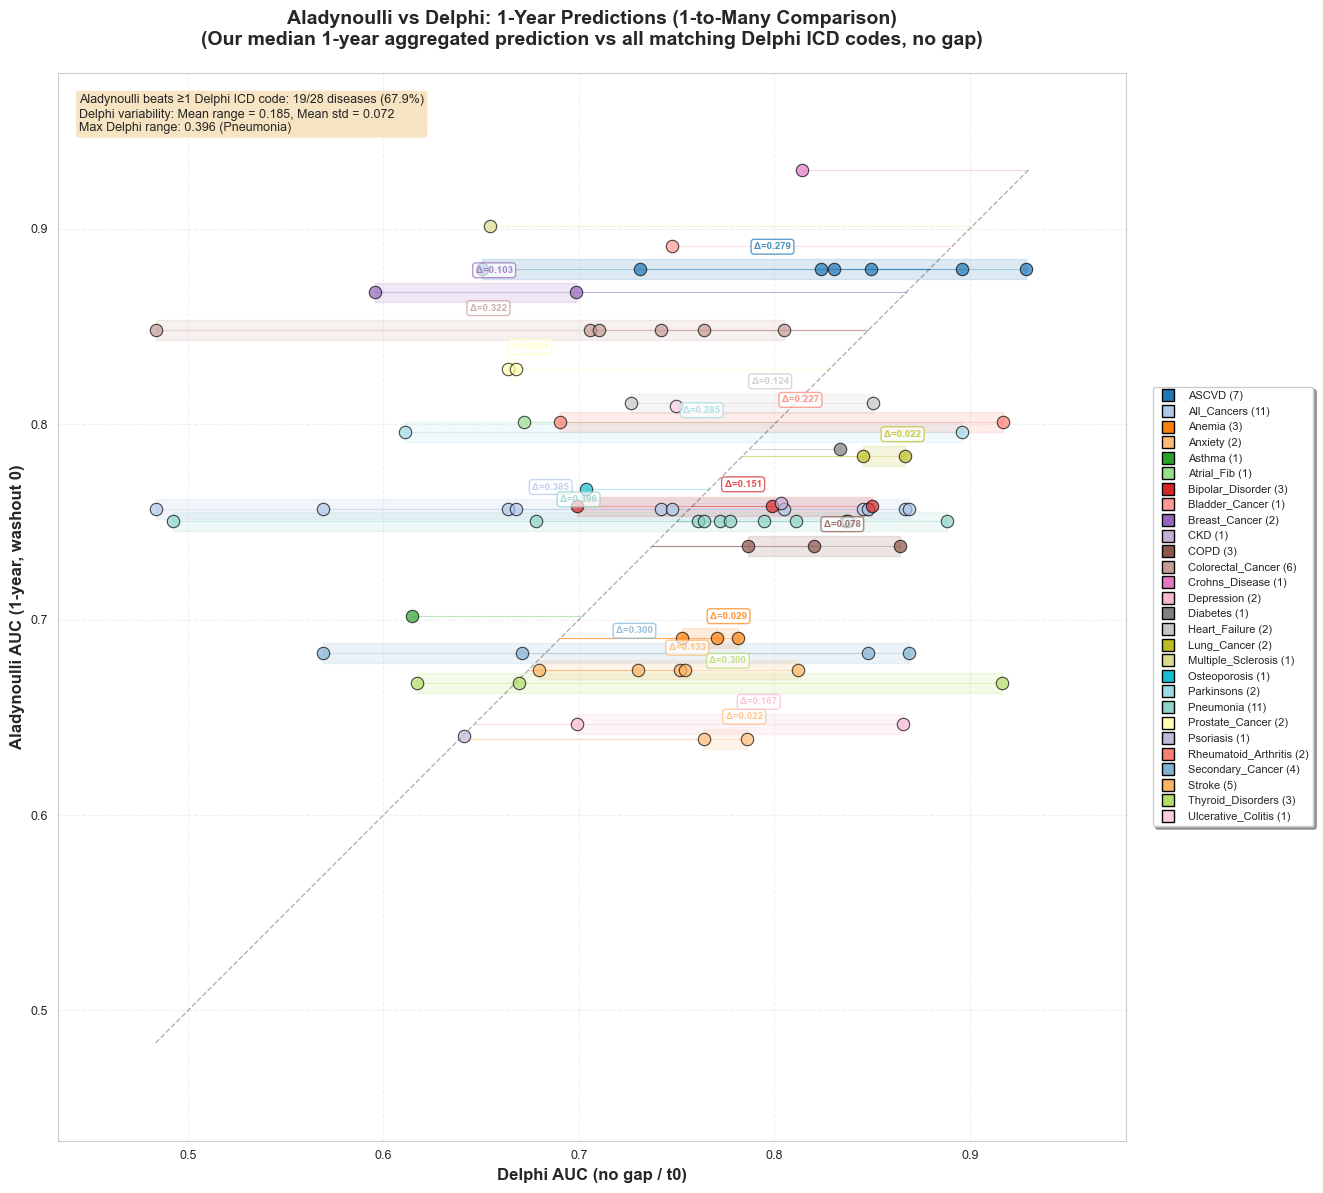

In [152]:
# Create 1-to-many visualization for 1-year predictions: Our single prediction vs all Delphi ICD codes, color-coded by disease
# UPDATED: Delphi on x-axis, Aladynoulli on y-axis

if 'comparison_1yr' in locals() and len(comparison_1yr) > 0:
    # Set up the plot style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (16, 12)
    plt.rcParams['font.size'] = 9
    
    # Get unique diseases and assign colors (use same colors as t0 plot for consistency)
    unique_diseases = sorted(comparison_1yr['Disease'].unique())
    n_diseases = len(unique_diseases)
    
    # Use a colormap with enough distinct colors
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    if n_diseases > 20:
        # Extend with another colormap if needed
        colors2 = plt.cm.Set3(np.linspace(0, 1, 12))
        colors = np.vstack([colors, colors2])
    
    disease_colors = {disease: colors[i % len(colors)] for i, disease in enumerate(unique_diseases)}
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Plot diagonal line (y=x) for reference
    min_val = min(comparison_1yr['Aladynoulli_1yr'].min(), comparison_1yr['Delphi_no_gap'].min())
    max_val = max(comparison_1yr['Aladynoulli_1yr'].max(), comparison_1yr['Delphi_no_gap'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='y=x (equal performance)')
    
    # Calculate Delphi variability statistics
    delphi_variability = []
    
    # For each disease, plot lines connecting our prediction to all Delphi points
    for disease in unique_diseases:
        disease_data = comparison_1yr[comparison_1yr['Disease'] == disease]
        our_auc = disease_data['Aladynoulli_1yr'].iloc[0]  # Same for all rows
        delphi_aucs = disease_data['Delphi_no_gap'].values
        color = disease_colors[disease]
        
        # Calculate variability metrics
        if len(delphi_aucs) > 1:
            delphi_range = delphi_aucs.max() - delphi_aucs.min()
            delphi_std = delphi_aucs.std()
            delphi_variability.append({
                'Disease': disease,
                'Range': delphi_range,
                'Std': delphi_std,
                'Min': delphi_aucs.min(),
                'Max': delphi_aucs.max(),
                'N': len(delphi_aucs)
            })
            
            # Draw shaded region showing Delphi range (behind everything) - HORIZONTAL BAND (Delphi on x-axis)
            ax.fill_between([delphi_aucs.min(), delphi_aucs.max()],
                           [our_auc - 0.005, our_auc - 0.005], 
                           [our_auc + 0.005, our_auc + 0.005],
                           color=color, alpha=0.15, zorder=0)
        
        # Draw lines from our point to each Delphi point - HORIZONTAL LINES (Delphi on x-axis)
        for delphi_auc in delphi_aucs:
            ax.plot([delphi_auc, our_auc], [our_auc, our_auc], 
                   color=color, alpha=0.3, linewidth=0.8, zorder=1)
        
        # Plot all Delphi points for this disease - DELPHI ON X-AXIS, ALA ON Y-AXIS
        ax.scatter(delphi_aucs, [our_auc] * len(delphi_aucs), 
                  s=80, c=[color], marker='o', 
                  edgecolors='black', linewidths=0.8, 
                  alpha=0.7, zorder=2)
        
        # Add text annotation showing range for diseases with multiple Delphi codes - SWAPPED POSITION
        if len(delphi_aucs) > 1:
            range_text = f"Δ={delphi_range:.3f}"
            ax.text((delphi_aucs.min() + delphi_aucs.max()) / 2, our_auc + 0.01,
                   range_text, fontsize=7, color=color, 
                   weight='bold', alpha=0.8, zorder=4,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            edgecolor=color, alpha=0.7, linewidth=1))
    
    # Labels and title - SWAPPED AXES
    ax.set_xlabel('Delphi AUC (no gap / t0)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Aladynoulli AUC (1-year, washout 0)', fontsize=12, fontweight='bold')
    ax.set_title('Aladynoulli vs Delphi: 1-Year Predictions (1-to-Many Comparison)\n(Our median 1-year aggregated prediction vs all matching Delphi ICD codes, no gap)', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Set equal aspect ratio and limits
    ax.set_aspect('equal', adjustable='box')
    margin = 0.05
    ax.set_xlim([min_val - margin, max_val + margin])
    ax.set_ylim([min_val - margin, max_val + margin])
    
    # Add legend (outside plot, showing all diseases)
    legend_elements = []
    for i, disease in enumerate(unique_diseases):  # Show all diseases
        color = disease_colors[disease]
        n_delphi = len(comparison_1yr[comparison_1yr['Disease'] == disease])
        legend_elements.append(
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, 
                      markersize=8, markeredgecolor='black', markeredgewidth=1,
                      label=f'{disease} ({n_delphi})', linestyle='None')
        )
    
    # Place legend outside plot
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), 
             fontsize=8, frameon=True, fancybox=True, shadow=True)
    
    # Add text annotation with summary stats
    wins_by_disease = comparison_1yr.groupby('Disease')['Advantage'].apply(lambda x: (x > 0).any())
    n_wins = wins_by_disease.sum()
    n_diseases_total = len(wins_by_disease)
    
    # Calculate Delphi variability summary
    if len(delphi_variability) > 0:
        variability_df = pd.DataFrame(delphi_variability)
        mean_range = variability_df['Range'].mean()
        mean_std = variability_df['Std'].mean()
        max_range = variability_df['Range'].max()
        max_range_disease = variability_df.loc[variability_df['Range'].idxmax(), 'Disease']
        
        stats_text = (f'Aladynoulli beats ≥1 Delphi ICD code: {n_wins}/{n_diseases_total} diseases ({n_wins/n_diseases_total*100:.1f}%)\n'
                     f'Delphi variability: Mean range = {mean_range:.3f}, Mean std = {mean_std:.3f}\n'
                     f'Max Delphi range: {max_range:.3f} ({max_range_disease})')
    else:
        stats_text = f'Aladynoulli beats ≥1 Delphi ICD code: {n_wins}/{n_diseases_total} diseases ({n_wins/n_diseases_total*100:.1f}%)'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           fontsize=9, verticalalignment='top', 
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Print variability summary
    if len(delphi_variability) > 0:
        print("\n" + "="*80)
        print("DELPHI VARIABILITY SUMMARY (1-YEAR PREDICTIONS):")
        print("="*80)
        variability_df = pd.DataFrame(delphi_variability)
        variability_df = variability_df.sort_values('Range', ascending=False)
        print(f"\nMean range across diseases: {variability_df['Range'].mean():.4f}")
        print(f"Mean std across diseases: {variability_df['Std'].mean():.4f}")
        print(f"\nTop 10 diseases by Delphi variability (range):")
        print(variability_df[['Disease', 'N', 'Range', 'Std', 'Min', 'Max']].head(10).to_string(index=False))
    
    plt.tight_layout()
    
    # Save figure
    figures_dir = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/figures')
    figures_dir.mkdir(parents=True, exist_ok=True)
    fig_path = figures_dir / 'delphi_comparison_phecode_mapping_1yr_1tomany.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved figure to: {fig_path}")
    
    plt.show()
else:
    print("⚠️  Cannot create visualization without comparison_1yr data")



Step 12: Combined Comparison File

Create a single file combining both t0 and 1-year predictions with Delphi t0.


In [148]:
# Combine both comparisons into a single file
if 'comparison' in locals() and 'comparison_1yr' in locals():
    # Merge on Disease and Delphi_ICD_code
    combined = comparison[['Disease', 'Delphi_ICD_code', 'Delphi_name', 'Aladynoulli_t0', 'Delphi_t0']].merge(
        comparison_1yr[['Disease', 'Delphi_ICD_code', 'Aladynoulli_1yr']],
        on=['Disease', 'Delphi_ICD_code'],
        how='outer'  # Use outer to keep all rows from both
    )
    
    # Calculate advantages for both
    combined['Advantage_t0'] = combined['Aladynoulli_t0'] - combined['Delphi_t0']
    combined['Advantage_1yr'] = combined['Aladynoulli_1yr'] - combined['Delphi_t0']
    
    # Add win indicators
    combined['Win_t0?'] = combined['Advantage_t0'].apply(lambda x: '✓' if pd.notna(x) and x > 0 else '✗' if pd.notna(x) else '')
    combined['Win_1yr?'] = combined['Advantage_1yr'].apply(lambda x: '✓' if pd.notna(x) and x > 0 else '✗' if pd.notna(x) else '')
    
    # Sort by Disease and then by Advantage_1yr (descending)
    combined = combined.sort_values(['Disease', 'Advantage_1yr'], ascending=[True, False], na_position='last')
    
    # Reorder columns
    combined = combined[['Disease', 'Delphi_ICD_code', 'Delphi_name', 
                         'Aladynoulli_t0', 'Aladynoulli_1yr', 'Delphi_t0',
                         'Advantage_t0', 'Advantage_1yr', 'Win_t0?', 'Win_1yr?']]
    
    print("="*80)
    print("COMBINED COMPARISON: Aladynoulli t0 & 1-year vs Delphi t0")
    print("="*80)
    print(f"\n{len(combined)} comparisons ({len(set(combined['Disease']))} diseases)")
    print(f"  Aladynoulli t0: {combined['Aladynoulli_t0'].notna().sum()} comparisons")
    print(f"  Aladynoulli 1-year: {combined['Aladynoulli_1yr'].notna().sum()} comparisons")
    print(f"  Delphi t0: {combined['Delphi_t0'].notna().sum()} comparisons")
    
    # Count wins
    wins_t0 = (combined['Advantage_t0'] > 0).sum()
    wins_1yr = (combined['Advantage_1yr'] > 0).sum()
    total_t0 = combined['Advantage_t0'].notna().sum()
    total_1yr = combined['Advantage_1yr'].notna().sum()
    
    print(f"\nAladynoulli wins (t0 vs Delphi t0): {wins_t0}/{total_t0} ({wins_t0/total_t0*100:.1f}%)")
    print(f"Aladynoulli wins (1-year vs Delphi t0): {wins_1yr}/{total_1yr} ({wins_1yr/total_1yr*100:.1f}%)")
    
    print("\n" + "-"*80)
    print("Example: ASCVD (showing all Delphi ICD code comparisons):")
    print("-"*80)
    if 'ASCVD' in combined['Disease'].values:
        ascdv_combined = combined[combined['Disease'] == 'ASCVD']
        print(ascdv_combined[['Disease', 'Delphi_ICD_code', 'Aladynoulli_t0', 'Aladynoulli_1yr', 
                              'Delphi_t0', 'Advantage_t0', 'Advantage_1yr', 'Win_t0?', 'Win_1yr?']].to_string(index=False))
    
    # Save combined results
    output_dir = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/comparisons/pooled_retrospective')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    combined.to_csv(output_dir / 'delphi_comparison_phecode_mapping_combined_t0_1yr.csv', index=False)
    print(f"\n✓ Combined results saved to: {output_dir / 'delphi_comparison_phecode_mapping_combined_t0_1yr.csv'}")
else:
    print("⚠️  Cannot create combined file without both comparison and comparison_1yr data")


COMBINED COMPARISON: Aladynoulli t0 & 1-year vs Delphi t0

82 comparisons (28 diseases)
  Aladynoulli t0: 82 comparisons
  Aladynoulli 1-year: 82 comparisons
  Delphi t0: 82 comparisons

Aladynoulli wins (t0 vs Delphi t0): 36/82 (43.9%)
Aladynoulli wins (1-year vs Delphi t0): 37/82 (45.1%)

--------------------------------------------------------------------------------
Example: ASCVD (showing all Delphi ICD code comparisons):
--------------------------------------------------------------------------------
Disease Delphi_ICD_code  Aladynoulli_t0  Aladynoulli_1yr  Delphi_t0  Advantage_t0  Advantage_1yr Win_t0? Win_1yr?
  ASCVD             I21        0.880921         0.879477   0.650164      0.230757       0.229313       ✓        ✓
  ASCVD             I20        0.880921         0.879477   0.731225      0.149696       0.148252       ✓        ✓
  ASCVD             I25        0.880921         0.879477   0.823853      0.057068       0.055624       ✓        ✓
  ASCVD             I51        0

## Alternative Comparison: Simple String Matching (Manual Mapping)

This cell recreates the old manual mapping approach from `compare_delphi_1yr_import.py` using simple string matching to map Delphi ICD codes to our diseases. This provides a comparison to the Phecode-based mapping approach above.

**Method:**
- Uses simple string matching (ICD code prefix or disease name substring)
- Averages Delphi's AUCs across all matching ICD codes per disease
- Compares Aladynoulli's median 1-year predictions (washout 0) vs Delphi's 0-gap (t0) predictions


MANUAL DICTIONARY MAPPING COMPARISON

Mapped 28 diseases using manual dictionary mapping

ICD Code Mapping (showing which ICD codes map to each disease):
--------------------------------------------------------------------------------
  ASCVD: I21, I25 (2 codes)
  All_Cancers: C18, C50, D07 (3 codes)
  Anemia: D50 (1 codes)
  Anxiety: F41 (1 codes)
  Asthma: J45 (1 codes)
  Atrial_Fib: I48 (1 codes)
  Bipolar_Disorder: F31 (1 codes)
  Bladder_Cancer: C67 (1 codes)
  Breast_Cancer: C50 (1 codes)
  CKD: N18 (1 codes)
  COPD: J44 (1 codes)
  Colorectal_Cancer: C18 (1 codes)
  Crohns_Disease: K50 (1 codes)
  Depression: F32, F33 (2 codes)
  Diabetes: E11 (1 codes)
  Heart_Failure: I50 (1 codes)
  Lung_Cancer: C34 (1 codes)
  Multiple_Sclerosis: G35 (1 codes)
  Osteoporosis: M81 (1 codes)
  Parkinsons: G20 (1 codes)
  Pneumonia: J18 (1 codes)
  Prostate_Cancer: C61 (1 codes)
  Psoriasis: L40 (1 codes)
  Rheumatoid_Arthritis: M05, M06 (2 codes)
  Secondary_Cancer: C79 (1 codes)
  Stroke: I63

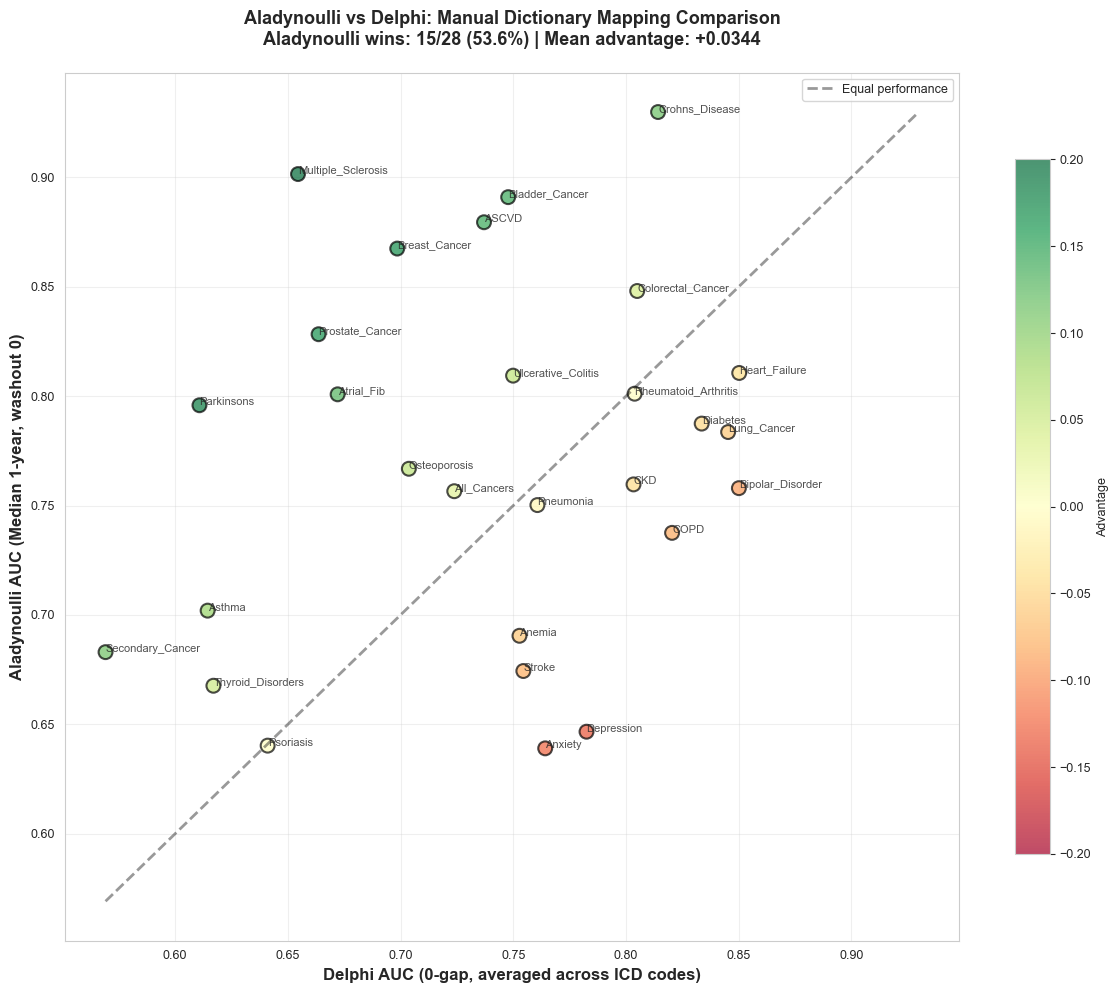

In [149]:
# Manual dictionary mapping approach (recreating compare_delphi_1yr_import.py logic)
# Uses the hardcoded disease-to-ICD mapping from the original script

# Get our disease names from Aladynoulli results
if aladynoulli_1yr is not None:
    our_disease_names = aladynoulli_1yr['Disease'].unique().tolist()
    
    # Load Delphi supplementary table if not already loaded
    if 'delphi_supp' not in locals():
        delphi_supp_path = Path('/Users/sarahurbut/Downloads/41586_2025_9529_MOESM3_ESM.csv')
        if delphi_supp_path.exists():
            delphi_supp = pd.read_csv(delphi_supp_path)
            print(f"✓ Loaded Delphi supplementary table: {len(delphi_supp)} rows")
        else:
            print(f"⚠️  Delphi supplementary table not found: {delphi_supp_path}")
            delphi_supp = None
    
    if delphi_supp is not None:
        # Manual disease category to ICD-10 code mappings (from compare_delphi_1yr_import.py)
        disease_icd_mapping = {
            'ASCVD': ['I21', 'I25'],  # Myocardial infarction, Coronary atherosclerosis
            'Diabetes': ['E11'],  # Type 2 diabetes
            'Atrial_Fib': ['I48'],  # Atrial fibrillation
            'CKD': ['N18'],  # Chronic renal failure
            'All_Cancers': ['C18', 'C50', 'D07'],  # Colon, Breast, Prostate
            'Stroke': ['I63'],  # Cerebral infarction
            'Heart_Failure': ['I50'],  # Heart failure
            'Pneumonia': ['J18'],  # Pneumonia
            'COPD': ['J44'],  # Chronic obstructive pulmonary disease
            'Osteoporosis': ['M81'],  # Osteoporosis
            'Anemia': ['D50'],  # Iron deficiency anemia
            'Colorectal_Cancer': ['C18'],  # Colon cancer
            'Breast_Cancer': ['C50'],  # Breast cancer
            'Prostate_Cancer': ['C61'],  # Prostate cancer
            'Lung_Cancer': ['C34'],  # Lung cancer
            'Bladder_Cancer': ['C67'],  # Bladder cancer
            'Secondary_Cancer': ['C79'],  # Secondary malignant neoplasm
            'Depression': ['F32', 'F33'],  # Depressive disorders
            'Anxiety': ['F41'],  # Anxiety disorders
            'Bipolar_Disorder': ['F31'],  # Bipolar disorder
            'Rheumatoid_Arthritis': ['M05', 'M06'],  # Rheumatoid arthritis
            'Psoriasis': ['L40'],  # Psoriasis
            'Ulcerative_Colitis': ['K51'],  # Ulcerative colitis
            'Crohns_Disease': ['K50'],  # Crohn's disease
            'Asthma': ['J45'],  # Asthma
            'Parkinsons': ['G20'],  # Parkinson's disease
            'Multiple_Sclerosis': ['G35'],  # Multiple sclerosis
            'Thyroid_Disorders': ['E03']  # Hypothyroidism
        }
        
        # Extract Delphi AUCs for each disease category
        disease_icd_mapping_simple = {}  # Track which ICD codes map to which diseases
        
        # Identify Delphi column names
        name_col = None
        auc_0gap_female_col = None
        auc_0gap_male_col = None
        
        for col in delphi_supp.columns:
            col_lower = col.lower()
            if 'name' in col_lower and name_col is None:
                name_col = col
            if 'auc' in col_lower and 'female' in col_lower and 'no gap' in col_lower:
                auc_0gap_female_col = col
            if 'auc' in col_lower and 'male' in col_lower and 'no gap' in col_lower:
                auc_0gap_male_col = col
        
        if name_col:
            for disease_name, icd_codes in disease_icd_mapping.items():
                matching_rows = []
                
                for icd_code in icd_codes:
                    # Find ICD-10 codes that start with the pattern
                    matches = delphi_supp[delphi_supp[name_col].str.contains(f'^{icd_code}', regex=True, na=False)]
                    if len(matches) > 0:
                        matching_rows.append(matches)
                
                if len(matching_rows) > 0:
                    # Combine all matching rows
                    combined = pd.concat(matching_rows).drop_duplicates()
                    
                    # Store ICD code mappings for this disease
                    disease_icd_mapping_simple[disease_name] = []
                    
                    for idx, row in combined.iterrows():
                        name_val = str(row[name_col])
                        
                        # Extract ICD code
                        import re
                        icd_match = re.match(r'^([A-Z]\d{2})', name_val)
                        if icd_match:
                            icd_code = icd_match.group(1)
                        else:
                            continue
                        
                        # Get AUCs for 0-gap (t0)
                        female_auc = row[auc_0gap_female_col] if auc_0gap_female_col in row.index and pd.notna(row[auc_0gap_female_col]) else None
                        male_auc = row[auc_0gap_male_col] if auc_0gap_male_col in row.index and pd.notna(row[auc_0gap_male_col]) else None
                        
                        # Average if both available
                        if female_auc is not None and male_auc is not None:
                            avg_auc = (female_auc + male_auc) / 2
                        elif female_auc is not None:
                            avg_auc = female_auc
                        elif male_auc is not None:
                            avg_auc = male_auc
                        else:
                            continue
                        
                        disease_icd_mapping_simple[disease_name].append({
                            'ICD_code': icd_code,
                            'Delphi_name': name_val,
                            'Delphi_0gap': avg_auc
                        })
        
        # Create comparison: average Delphi AUCs per disease
        simple_comparison_results = []
        
        for disease in our_disease_names:
            if disease in disease_icd_mapping_simple and len(disease_icd_mapping_simple[disease]) > 0:
                # Get Aladynoulli AUC
                ala_auc = aladynoulli_1yr[aladynoulli_1yr['Disease'] == disease]['Aladynoulli_1yr'].iloc[0]
                
                # Average Delphi AUCs across all matching ICD codes
                delphi_aucs = [item['Delphi_0gap'] for item in disease_icd_mapping_simple[disease]]
                avg_delphi_auc = np.mean(delphi_aucs)
                
                # Get ICD codes for display
                icd_codes = [item['ICD_code'] for item in disease_icd_mapping_simple[disease]]
                
                simple_comparison_results.append({
                    'Disease': disease,
                    'Aladynoulli_1yr': ala_auc,
                    'Delphi_0gap_avg': avg_delphi_auc,
                    'N_ICD_codes': len(icd_codes),
                    'ICD_codes': ', '.join(icd_codes),
                    'Advantage': ala_auc - avg_delphi_auc
                })
        
        simple_comparison_df = pd.DataFrame(simple_comparison_results)
        
        if len(simple_comparison_df) > 0:
            simple_comparison_df = simple_comparison_df.sort_values('Advantage', ascending=False)
            
            print("="*80)
            print("MANUAL DICTIONARY MAPPING COMPARISON")
            print("="*80)
            print(f"\nMapped {len(simple_comparison_df)} diseases using manual dictionary mapping")
            print(f"\nICD Code Mapping (showing which ICD codes map to each disease):")
            print("-"*80)
            for disease, items in sorted(disease_icd_mapping_simple.items()):
                icd_codes = [item['ICD_code'] for item in items]
                print(f"  {disease}: {', '.join(icd_codes)} ({len(icd_codes)} codes)")
            
            print("\n" + "="*80)
            print("COMPARISON: Aladynoulli Median 1-Year (Washout 0) vs Delphi 0-Gap (Averaged)")
            print("="*80)
            wins = simple_comparison_df[simple_comparison_df['Advantage'] > 0]
            print(f"\nAladynoulli wins: {len(wins)}/{len(simple_comparison_df)} diseases ({len(wins)/len(simple_comparison_df)*100:.1f}%)")
            print(f"Mean advantage: {simple_comparison_df['Advantage'].mean():.4f}")
            print(f"Median advantage: {simple_comparison_df['Advantage'].median():.4f}")
            
            print("\nTop 10 diseases by advantage:")
            print(simple_comparison_df.head(10)[['Disease', 'Aladynoulli_1yr', 'Delphi_0gap_avg', 'N_ICD_codes', 'Advantage']].to_string(index=False))
            
            print("\nBottom 10 diseases (Delphi wins):")
            print(simple_comparison_df.tail(10)[['Disease', 'Aladynoulli_1yr', 'Delphi_0gap_avg', 'N_ICD_codes', 'Advantage']].to_string(index=False))
            
            # Save results
            output_dir = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/comparisons/pooled_retrospective')
            output_dir.mkdir(parents=True, exist_ok=True)
            
            simple_comparison_df.to_csv(output_dir / 'delphi_comparison_simple_mapping_1yr.csv', index=False)
            print(f"\n✓ Results saved to: {output_dir / 'delphi_comparison_simple_mapping_1yr.csv'}")
            
            # Create visualization
            import matplotlib.pyplot as plt
            import seaborn as sns
            
            fig, ax = plt.subplots(figsize=(12, 10))
            
            scatter = ax.scatter(simple_comparison_df['Delphi_0gap_avg'], 
                               simple_comparison_df['Aladynoulli_1yr'],
                               s=100, alpha=0.7, c=simple_comparison_df['Advantage'],
                               cmap='RdYlGn', edgecolors='black', linewidth=1.5, vmin=-0.2, vmax=0.2)
            
            for idx, row in simple_comparison_df.iterrows():
                ax.annotate(row['Disease'], 
                           (row['Delphi_0gap_avg'], row['Aladynoulli_1yr']),
                           fontsize=8, alpha=0.8)
            
            max_val = max(simple_comparison_df['Delphi_0gap_avg'].max(), simple_comparison_df['Aladynoulli_1yr'].max())
            min_val = min(simple_comparison_df['Delphi_0gap_avg'].min(), simple_comparison_df['Aladynoulli_1yr'].min())
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.4, linewidth=2, label='Equal performance')
            
            ax.set_xlabel('Delphi AUC (0-gap, averaged across ICD codes)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Aladynoulli AUC (Median 1-year, washout 0)', fontsize=12, fontweight='bold')
            ax.set_title(f'Aladynoulli vs Delphi: Manual Dictionary Mapping Comparison\n'
                        f'Aladynoulli wins: {len(wins)}/{len(simple_comparison_df)} ({len(wins)/len(simple_comparison_df)*100:.1f}%) | '
                        f'Mean advantage: {simple_comparison_df["Advantage"].mean():+.4f}',
                        fontsize=13, fontweight='bold', pad=20)
            ax.legend(fontsize=9)
            ax.grid(alpha=0.3)
            plt.colorbar(scatter, ax=ax, label='Advantage', shrink=0.8)
            
            plt.tight_layout()
            
            # Save figure
            fig_path = Path('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/figures/delphi_comparison_simple_mapping_1yr.png')
            fig_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(fig_path, dpi=300, bbox_inches='tight')
            print(f"\n✓ Figure saved to: {fig_path}")
            plt.show()
        else:
            print("⚠️  No diseases matched using manual dictionary mapping")
        
    else:
        print("⚠️  Cannot perform simple mapping comparison without Delphi supplementary table")
else:
    print("⚠️  Cannot perform simple mapping comparison without Aladynoulli results")
